In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from starfish import FieldOfView, data
from starfish.types import Axes

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load Data into Starfish from the Cloud

In [2]:
experiment = data.osmFISH(use_test_data=True)
imgs = experiment["fov_000"].get_image(FieldOfView.PRIMARY_IMAGES)
print(imgs)

100%|██████████| 45/45 [00:02<00:00, 15.90it/s]

<starfish.ImageStack (r: 1, c: 1, z: 45, y: 2048, x: 2048)>


# Filter and Visualize Data

In [3]:
from starfish.image import Filter

filter_ghp = Filter.GaussianHighPass(sigma=(1,8,8), is_volume=True)
imgs_ghp = filter_ghp.run(imgs, in_place=False)

1it [00:00, 18.78it/s]


In [4]:
filter_laplace = Filter.Laplace(sigma=(0.2, 0.5, 0.5), is_volume=True)
imgs_ghp_laplace = filter_laplace.run(imgs_ghp, in_place=False)

1it [00:00, 17.96it/s]


In [5]:
mp = imgs_ghp_laplace.max_proj(Axes.ZPLANE)

100%|██████████| 1/1 [00:00<00:00, 84.10it/s]


100%|██████████| 1/1 [00:00<00:00, 90.47it/s]


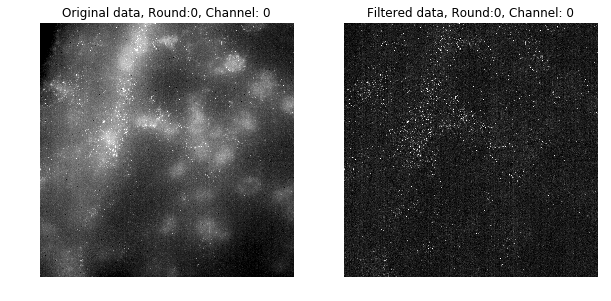

In [6]:
single_plane = imgs.max_proj(Axes.ZPLANE).xarray.sel({Axes.CH:0}).squeeze()
single_plane_filtered = mp.xarray.sel({Axes.CH: 0}).squeeze()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(single_plane, cmap='gray', clim = list(np.percentile(single_plane.data, [1, 99.9])))
plt.axis('off')
plt.title('Original data, Round:0, Channel: 0')
plt.subplot(122)
plt.imshow(single_plane_filtered, cmap='gray', clim = list(np.percentile(single_plane_filtered.data, [1, 99.9])))
plt.title('Filtered data, Round:0, Channel: 0')
plt.axis('off');

# Save images

In [7]:
image_stack = mp
# image_stack = imgs_ghp_laplace

In [8]:
# Get the number of channels in the ImageStack
num_ch = image_stack.num_chs

# Get the number of round in the ImageStack
num_rnd = image_stack.num_rounds

# Get the number of z slices in the ImageStack
num_z = image_stack.num_zplanes

print('%d rounds, %d channels, and %d z slice(s)' % (num_rnd, num_ch, num_z))

1 rounds, 1 channels, and 1 z slice(s)


In [9]:
from skimage import io

# Iterate through the images and save them to disk
for rnd in range(num_rnd):
    for channel in range(num_ch):
        for z in range(num_z):
            # Create the file name
            file_name = 'ISS_rnd%d_ch%d_z%d.png' % (rnd, channel, z)
            
            # Create the selector. This dictionary selects which slice (i.e., round, channel, z coords)
            # to select from the image stack
            selector = {
                Axes.ROUND: rnd,
                Axes.CH: channel,
                Axes.ZPLANE: z
            }
            
            # Get the slice
            (im, _) = image_stack.get_slice(selector)
            
            # Save the slice
            io.imsave(file_name, im, check_contrast=False)


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ISS_rnd0_ch0_z0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
